# Apple stock price GARCH analysis

## Import library

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

In [7]:
# Define stock tickers
tickers = ["AAPL", "MSFT", "NVDA"]

# Define time range
start_date = "2020-01-01"
end_date = "2021-01-01"

# Download stock data
stock_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, ignore_tz=True)

# Extract only the 'Close' prices
data = stock_data["Close"]
data.columns = tickers

data

[*********************100%***********************]  3 of 3 completed


,AAPL,MSFT,NVDA
Date,,,
2020-01-02,72.716064,153.323288,5.972160
2020-01-03,72.009125,151.414078,5.876571
2020-01-06,72.582909,151.805511,5.901215
2020-01-07,72.241554,150.421371,5.972660
2020-01-08,73.403641,152.817337,5.983861
...,...,...,...
2020-12-24,128.905823,214.883362,12.959664
2020-12-28,133.516205,217.015274,12.866158
2020-12-29,131.738480,216.233841,12.909296


In [10]:
data.isnull().sum()

,0
AAPL,0
MSFT,0
NVDA,0


In [11]:
data.describe()

,AAPL,MSFT,NVDA
count,253.000000,253.000000,253.000000
mean,92.836981,185.298199,9.858652
std,21.444429,22.545255,2.926819
min,54.449886,129.621109,4.891976
25%,74.962822,166.596985,6.807171
50%,89.189926,193.802231,9.581337
75%,112.867683,204.421524,12.953094
max,133.516205,222.885468,14.519510


# Applce stock price visualization

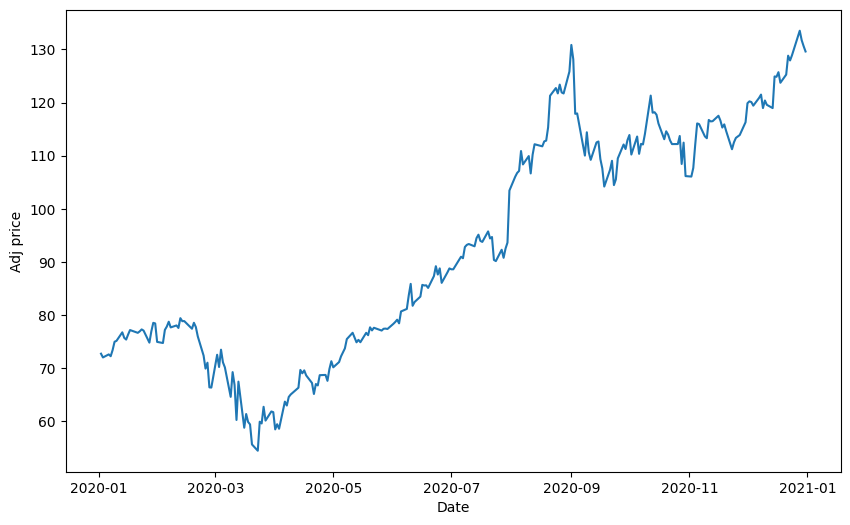

In [12]:
plt.figure(figsize=(10,6))
plt.plot(data.index,data['AAPL'])
plt.xlabel('Date')
plt.ylabel('Adj price')
plt.show()

In [15]:
data = data.copy()
data['Return'] = data['AAPL'].pct_change()
data.dropna(inplace=True)

# Apple stock Return visualization

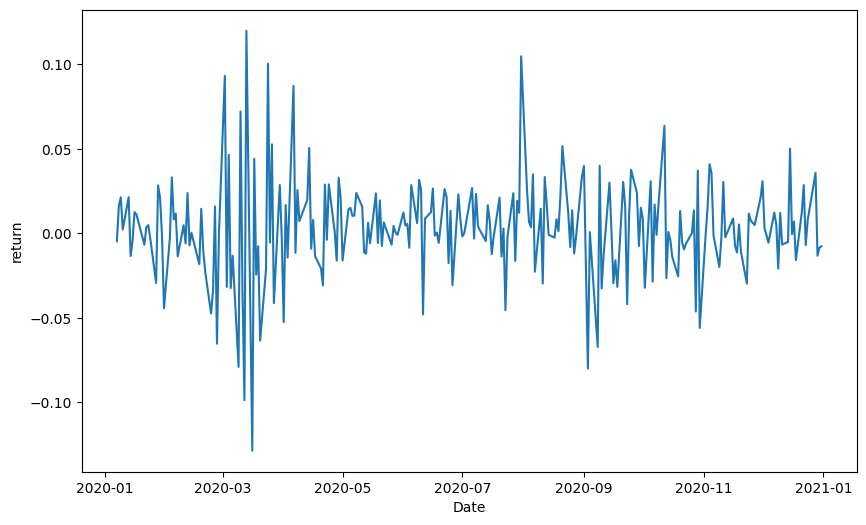

In [27]:
plt.figure(figsize=(10,6))
plt.plot(data.index,data['Return'])
plt.xlabel('Date')
plt.ylabel('return')
plt.show()

In [28]:
data['Return'].mean()

0.0027563521931218016

## Augmented dickey fuller test

In [16]:
result = adfuller(data['Return'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The data satisfies stationarity. Differencing is not required.")
else:
    print("The data does not satisfy stationarity. Differencing is required.")

ADF Statistic: -4.948547570983009
p-value: 2.8029858362325125e-05
The data satisfies stationarity. Differencing is not required.


# Auto correlation

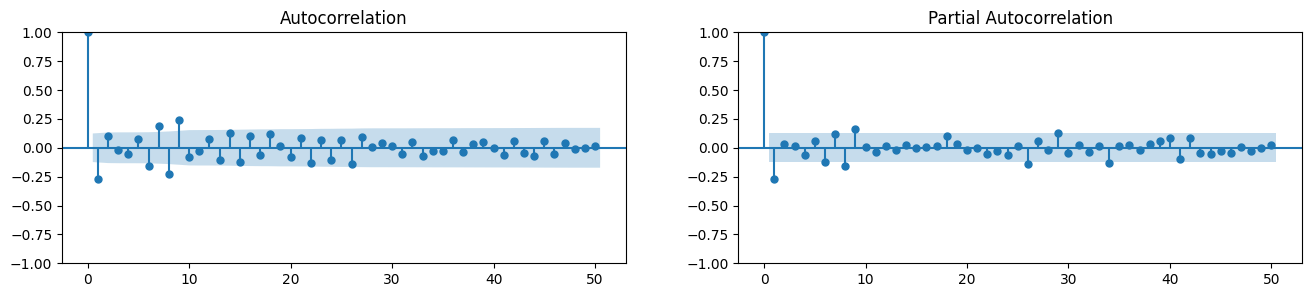

In [17]:
# Draw Autocorrelation and Partial Autocorrelation Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(data['Return'], lags=50, ax=axes[0])
plot_pacf(data['Return'], lags=50, ax=axes[1])

# Show the figure only once
plt.show()

The return data satisfies stationarity (ADF test) and exhibits little to no autocorrelation (ACF/PACF analysis). Therefore, instead of using an ARMA model, we applied GARCH and EGARCH to model volatility.

## Heteroskedasticity

In [26]:
arch_test = het_arch(data['Return'])
print("ARCH Test Statistic:", arch_test[0])
print("p-value:", arch_test[1])


ARCH Test Statistic: 49.29169952918716
p-value: 3.601285198231271e-07


Since the mean of the return data is zero, we consider the original returns as residuals and use the ARCH LM test to verify the heteroskedasticity in the data. The ARCH Test Statistic is 49.29169952918716 with a p-value of 3.601285198231271e-07, which confirms the presence of heteroskedasticity

# GARCH

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008648. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -563.2360763621055
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                563.236
Distribution:                  Normal   AIC:                          -1118.47
Method:            Maximum Likelihood   BIC:                          -1104.37
                                        No. Observations:                  251
Date:                Thu, Mar 13 2025   Df Residuals:                      250
Time:                        15:49:06   Df Model:                            1
                                 Mean Model                                 
    

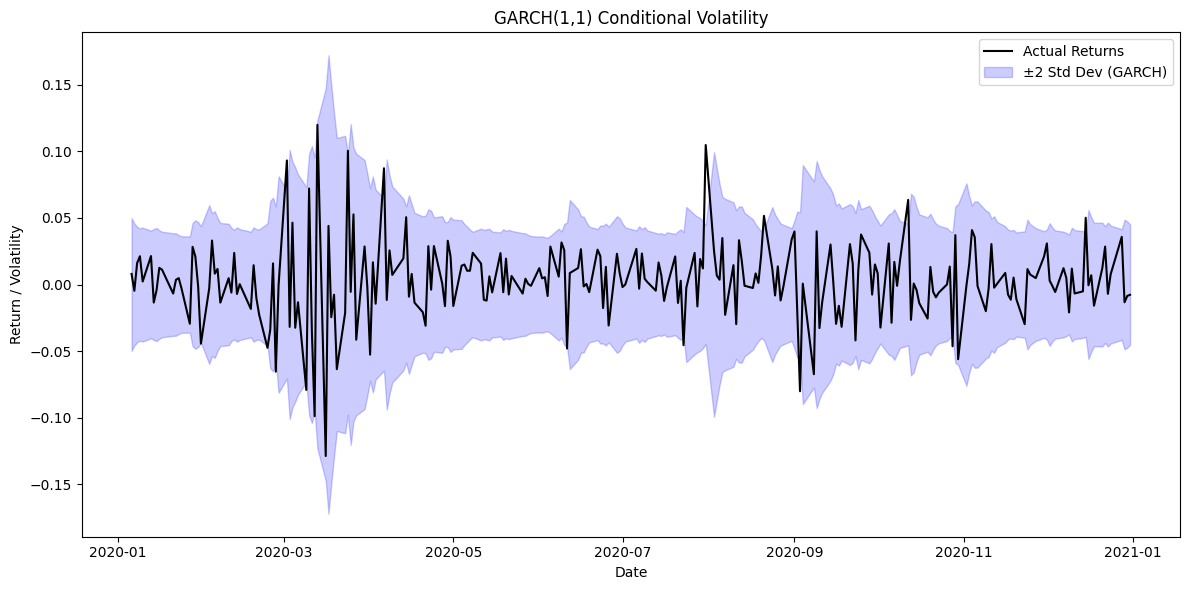

In [18]:
# Fit GARCH(1,1) model (mean equation set to constant)
garch_model = arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
garch_fitted = garch_model.fit(update_freq=5)

# Print GARCH model summary
print(garch_fitted.summary())

# GARCH conditional volatility (standard deviation)
sigma = garch_fitted.conditional_volatility

# Plot GARCH conditional volatility
plt.figure(figsize=(12, 6))

# Actual return data
plt.plot(returns.index, returns, label="Actual Returns", color="black", linewidth=1.5)

# GARCH volatility confidence band (±2 standard deviations)
plt.fill_between(returns.index, -2 * sigma, 2 * sigma, color="blue", alpha=0.2, label="±2 Std Dev (GARCH)")

plt.title("GARCH(1,1) Conditional Volatility")
plt.xlabel("Date")
plt.ylabel("Return / Volatility")
plt.legend()
plt.tight_layout()
plt.show()


#EGARCH

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008648. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     40,   Neg. LLF: 276105740.56558406
Iteration:     10,   Func. Count:     67,   Neg. LLF: -563.5590750991036
Optimization terminated successfully    (Exit mode 0)
            Current function value: -563.5590750991036
            Iterations: 10
            Function evaluations: 67
            Gradient evaluations: 10
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                563.559
Distribution:                  Normal   AIC:                          -1119.12
Method:            Maximum Likelihood   BIC:                          -1105.02
                                        No. Observations:                  251
Date:                Thu, Mar 13 2025   Df Residuals:                      250
Time:       

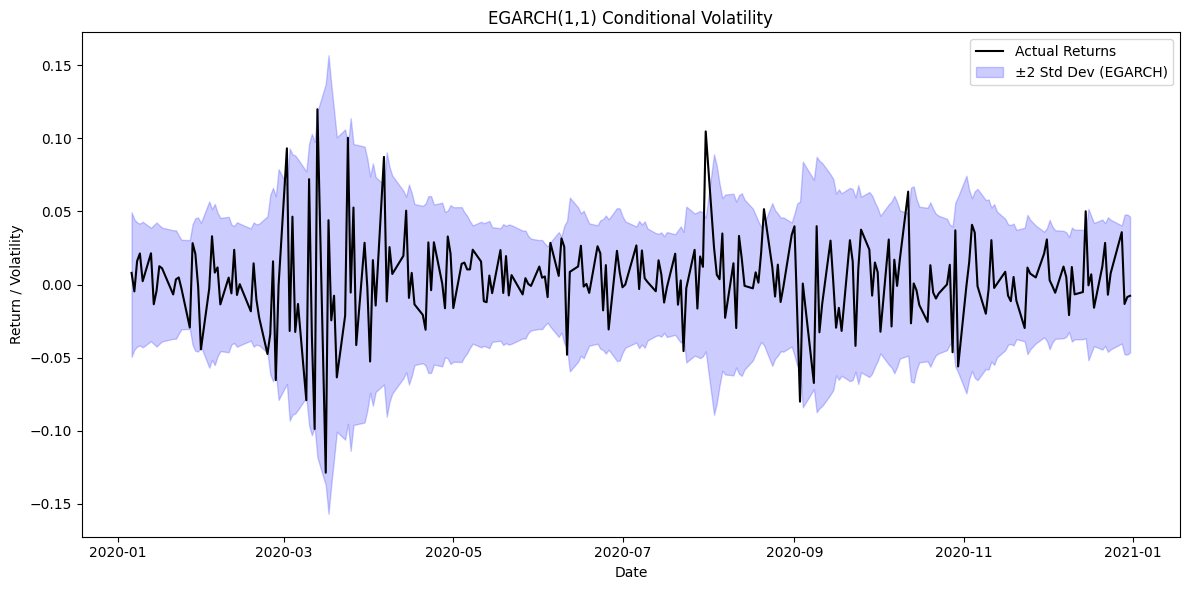

In [19]:
# Fit EGARCH(1,1) model (mean equation set to constant)
egarch_model = arch_model(returns, mean='Constant', vol='EGARCH', p=1, q=1, dist='normal')
egarch_fitted = egarch_model.fit(update_freq=5)

# Print EGARCH model summary
print(egarch_fitted.summary())

# EGARCH conditional volatility (standard deviation)
sigma = egarch_fitted.conditional_volatility

# Plot EGARCH conditional volatility
plt.figure(figsize=(12, 6))

# Actual return data
plt.plot(returns.index, returns, label="Actual Returns", color="black", linewidth=1.5)

# EGARCH volatility confidence band (±2 standard deviations)
plt.fill_between(returns.index, -2 * sigma, 2 * sigma, color="blue", alpha=0.2, label="±2 Std Dev (EGARCH)")

plt.title("EGARCH(1,1) Conditional Volatility")
plt.xlabel("Date")
plt.ylabel("Return / Volatility")
plt.legend()
plt.tight_layout()
plt.show()

In the GARCH/EGARCH model, omega represents the long-term unconditional variance, alpha captures the impact of recent shocks on current volatility through the squared error term, and beta reflects the persistence of past volatility by incorporating the previous period's predicted variance. The statistical significance of these three parameters indicates that both recent shocks and past volatility significantly influence current volatility, confirming that the model effectively captures the time-varying nature of volatility in the data. The squared error term represents the past period's shock, meaning that if recent volatility is high, future volatility is also likely to remain high. The predicted variance from the previous period shows that past volatility affects current volatility. The baseline variance level is represented by alpha zero. Overall, the GARCH model predicts whether future volatility will be high or low, determining how much dispersion is expected in the data.

Both models exhibit similar levels of log-likelihood, AIC, and BIC metrics, indicating a well-fitted mean model. In the EGARCH model, omega is -0.5311, alpha is 0.3196, and beta is 0.9245. Since EGARCH models the logarithm of variance, a negative omega does not necessarily indicate an issue. On the other hand, in the GARCH model, omega is estimated at 5.1975e-05, alpha at 0.1480, and beta at 0.7904, with the parameter signs and magnitudes aligning with expected values. While both models yield statistically significant results, further residual diagnostics and predictive performance evaluation are necessary to comprehensively determine which model better captures the volatility clustering in the data.

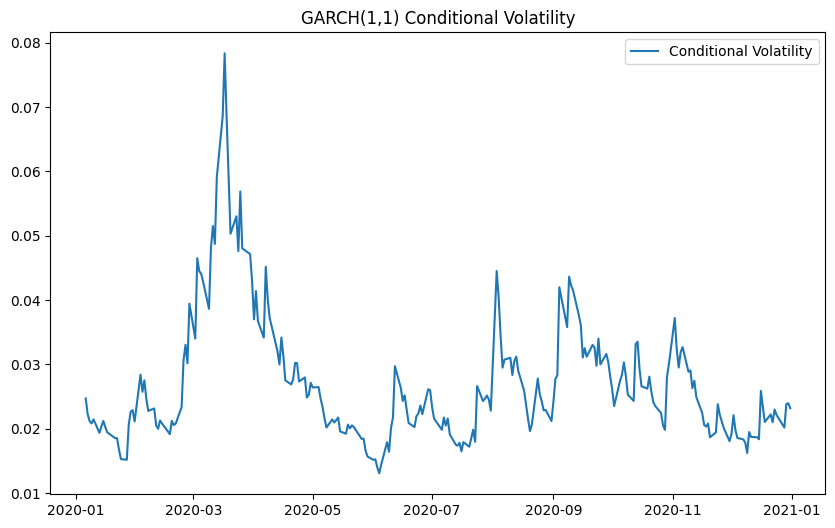

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(egarch_fitted.conditional_volatility, label='Conditional Volatility')
plt.title('GARCH(1,1) Conditional Volatility')
plt.legend()
plt.show()

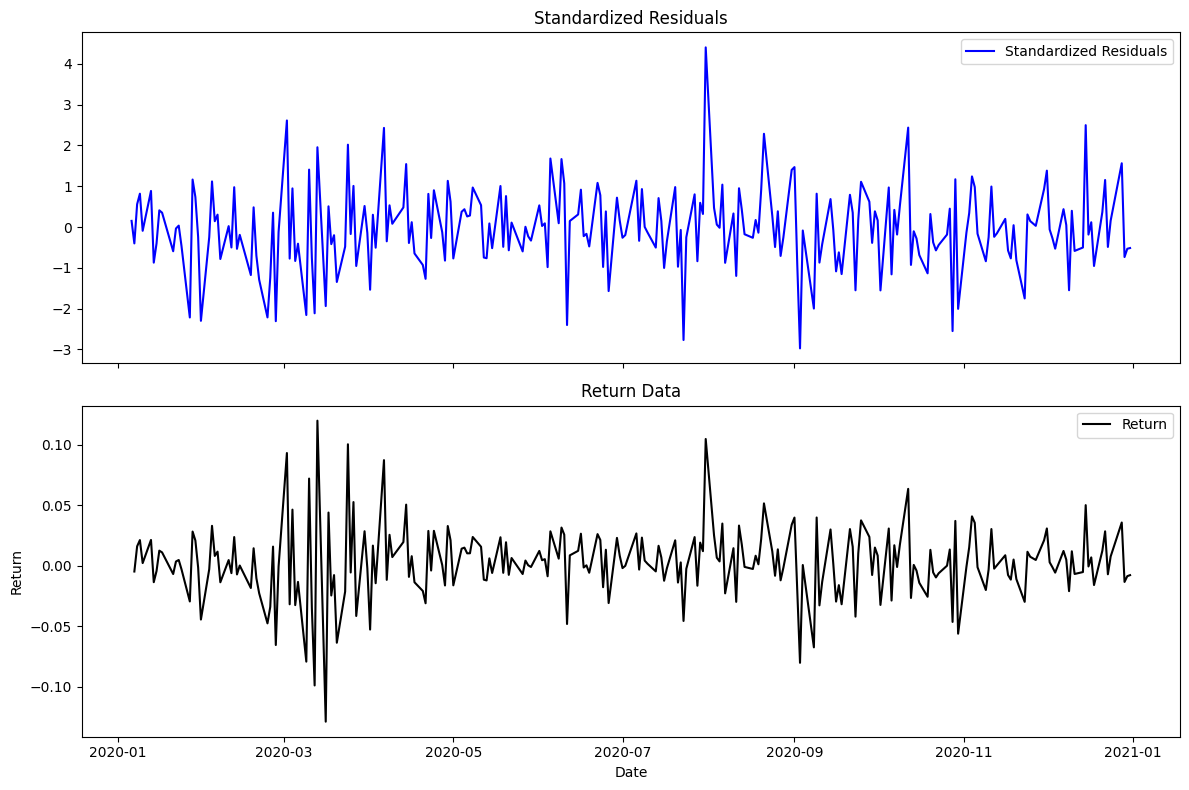

In [30]:
# Create subplots for Standardized Residuals and Return Data
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Standardized Residuals from the EGARCH model
residuals = egarch_fitted.resid / egarch_fitted.conditional_volatility
axes[0].plot(residuals, label='Standardized Residuals', color='blue')
axes[0].set_title('Standardized Residuals')
axes[0].legend()

# Plot the original return data
axes[1].plot(data.index, data['Return'], label='Return', color='black')
axes[1].set_title('Return Data')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The standardized residual plot is useful for assessing how well the EGARCH model captures volatility and whether the residuals behave like white noise. In this case, since the mean of the returns is nearly zero, the original returns are treated as residuals. By visualizing the volatility using the EGARCH model, we see that, aside from certain specific intervals, the model generally captures the volatility well.

In [35]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  14.056511    0.17043


The Ljung-Box test results indicate that the current EGARCH model has effectively removed the autocorrelation in the residuals, suggesting that additional modeling with ARMA-GARCH is likely unnecessary.





